## 1. Make classification data and get it ready

In [41]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [42]:
print(f"First 5 X features:\n{X[:5]}")
print(f"First 5 y features:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y features:
[1 1 1 1 0]


In [43]:
import pandas as pd

circles = pd.DataFrame(
    {
        'X1': X[:, 0],
        'X2': X[:, 1],
        'label': y
    })

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [44]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

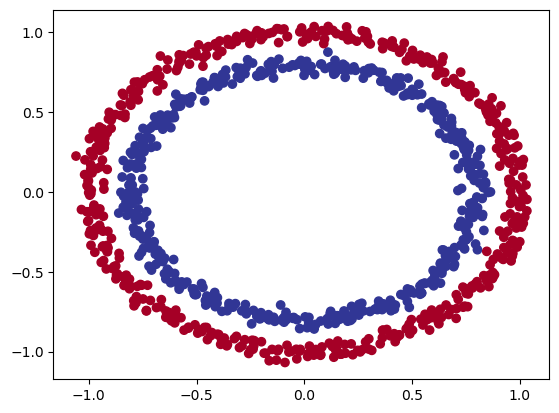

In [45]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [46]:
X.shape, y.shape

((1000, 2), (1000,))

In [47]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"X sample shape: {X_sample.shape} and y sample shape: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
X sample shape: (2,) and y sample shape: ()


In [48]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Model

In [50]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [51]:
class CircleModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 5)
        self.layer_2 = nn.Linear(5, 1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

model_0 = CircleModelv0().to(device)
model_0

CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

self.layer_1 takes 2 input features in_features=2 and produces 5 output features out_features=5.

This is known as having 5 hidden units or neurons.

This layer turns the input data from having 2 features to 5 features.

Why do this?

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

I say potentially because sometimes it doesn't work.

The number of hidden units you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

Since our dataset is small and simple, we'll keep it small.

The only rule with hidden units is that the next layer, in our case, self.layer_2 has to take the same in_features as the previous layer out_features.

That's why self.layer_2 has in_features=5, it takes the out_features=5 from self.layer_1 and performs a linear computation on them, turning them into out_features=1 (the same shape as y).

In [52]:
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.Linear(5, 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Woah, that looks much simpler than subclassing nn.Module, why not just always use nn.Sequential?

nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

In [53]:
untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 1- test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0', grad_fn=<SliceBackward0>)

First 1- test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Hmm, it seems there are the same amount of predictions as there are test labels but the predictions don't look like they're in the same form or shape as the test labels.

We've got a couple steps we can do to fix this.

PyTorch has two binary cross entropy implementations:

- torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
- torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).

Which one should you use?

The documentation for torch.nn.BCEWithLogitsLoss() states that it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of nn.Sigmoid and torch.nn.BCELoss() but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer.

For the optimizer we'll use torch.optim.SGD() to optimize the model parameters with learning rate 0.1

In [54]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

An evaluation metric can be used to offer another perspective on how your model is going.

If a loss function measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.

Of course, you could argue both of these are doing the same thing but evaluation metrics offer a different perspective.

After all, when evaluating your models it's good to look at things from multiple points of view.

There are several evaluation metrics that can be used for classification problems but let's start out with accuracy.

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

For example, a model that makes 99 correct predictions out of 100 will have an accuracy of 99%.

In [55]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

Before the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

In [56]:
y_logits = model_0(X_test.to(device))[:5]
print(y_logits)

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0', grad_fn=<SliceBackward0>)


Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our forward() method.

Which implements two layers of nn.Linear() which internally calls the following equation:

$$ \mathbf{y} = x \cdot \mathbf{Weights}^T + \mathbf{bias} $$

The raw outputs (unmodified) of this equation ($y$) and in turn, the raw outputs of our model are often referred to as logits.

That's what our model is outputing above when it takes in the input data ($x$ in the equation or X_test in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

In [57]:
y_preds_probs = torch.sigmoid(y_logits)
print(y_preds_probs)

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

They're now in the form of prediction probabilities (I usually refer to these as y_pred_probs), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

If y_pred_probs >= 0.5, y=1 (class 1)
If y_pred_probs < 0.5, y=0 (class 0)
To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [58]:
y_preds = torch.round(y_preds_probs)

y_preds_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_preds_label.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [59]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function (this will come later on).

And the use of the sigmoid activation function is not required when passing our model's raw outputs to the nn.BCEWithLogitsLoss (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

In [60]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | "
                  f"Train Loss: {loss:.5f} | "
                  f"Train Accuracy: {acc:.2f}% | "
                  f"Test Loss: {test_loss:.5f} | "
                  f"Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69796 | Train Accuracy: 51.88% | Test Loss: 0.69460 | Test Accuracy: 57.50%
Epoch: 10 | Train Loss: 0.69768 | Train Accuracy: 52.00% | Test Loss: 0.69438 | Test Accuracy: 58.00%
Epoch: 20 | Train Loss: 0.69742 | Train Accuracy: 52.00% | Test Loss: 0.69418 | Test Accuracy: 57.50%
Epoch: 30 | Train Loss: 0.69717 | Train Accuracy: 52.00% | Test Loss: 0.69401 | Test Accuracy: 56.50%
Epoch: 40 | Train Loss: 0.69695 | Train Accuracy: 51.62% | Test Loss: 0.69385 | Test Accuracy: 56.50%
Epoch: 50 | Train Loss: 0.69675 | Train Accuracy: 51.38% | Test Loss: 0.69370 | Test Accuracy: 56.00%
Epoch: 60 | Train Loss: 0.69656 | Train Accuracy: 51.38% | Test Loss: 0.69357 | Test Accuracy: 56.00%
Epoch: 70 | Train Loss: 0.69638 | Train Accuracy: 51.38% | Test Loss: 0.69345 | Test Accuracy: 56.50%
Epoch: 80 | Train Loss: 0.69621 | Train Accuracy: 51.25% | Test Loss: 0.69334 | Test Accuracy: 56.50%
Epoch: 90 | Train Loss: 0.69606 | Train Accuracy: 51.38% | Test Loss: 0.69324 | Tes

Hmm, what do you notice about the performance of our model?

It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

The accuracy is 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

## 4. Make predictions and evaluate the model
From the metrics it looks like our model is random guessing.

How could we investigate this further?

I've got an idea.

The data explorer's motto!

"Visualize, visualize, visualize!"

Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

To do so, we'll write some code to download and import the helper_functions.py script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called plot_decision_boundary() which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll also import plot_predictions()

In [61]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download.")
else:
    print("Downloading helper_functions.py")
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    r = requests.get(url)
    with open("helper_functions.py", "wb") as f:
        f.write(r.content)

helper_functions.py already exists, skipping download.


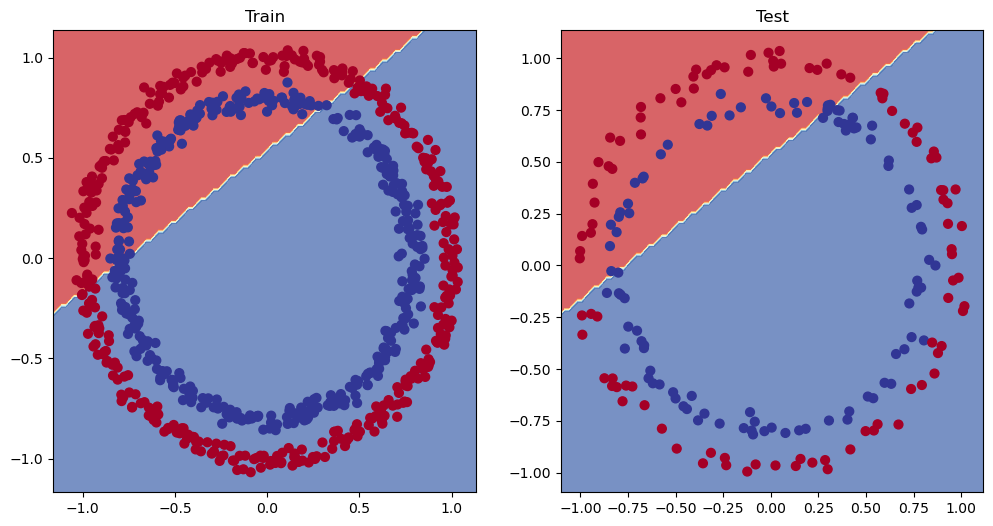

In [63]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Oh wow, it seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.

## 5. Improving a model (from a model perspective)
Ways to Improve a Neural Network (in simple terms):

Add More Layers (Make it Deeper):
Adding more layers helps the model learn more complex patterns in the data.

Add More Hidden Units (Make it Wider):
More neurons in each layer can help the model learn better, just like adding more brainpower.

Train for More Epochs:
Let the model look at the data more times. More practice often means better learning.

Change Activation Functions:
Instead of only using straight lines, using curved (non-linear) functions helps the model fit more complex data.

Adjust the Learning Rate:
This controls how big the model’s steps are while learning.

Too high: It may jump around and never learn well.

Too low: It may learn too slowly or get stuck.

Use the Right Loss Function:
The loss function tells the model how wrong it is. Use one that fits your type of problem:

Binary classification: use binary cross-entropy.

Multi-class classification: use categorical cross-entropy, etc.

Try Transfer Learning:
Use a model already trained on a similar task and adjust it for your problem. It’s like borrowing a smart brain and teaching it your stuff.

In [64]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [65]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [66]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [67]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | "
                  f"Train Loss: {loss:.5f} | "
                  f"Train Accuracy: {acc:.2f}% | "
                  f"Test Loss: {test_loss:.5f} | "
                  f"Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69396 | Train Accuracy: 50.88% | Test Loss: 0.69261 | Test Accuracy: 51.00%
Epoch: 100 | Train Loss: 0.69369 | Train Accuracy: 50.25% | Test Loss: 0.69269 | Test Accuracy: 50.00%
Epoch: 200 | Train Loss: 0.69351 | Train Accuracy: 50.12% | Test Loss: 0.69282 | Test Accuracy: 49.50%
Epoch: 300 | Train Loss: 0.69339 | Train Accuracy: 50.50% | Test Loss: 0.69295 | Test Accuracy: 49.00%
Epoch: 400 | Train Loss: 0.69329 | Train Accuracy: 50.38% | Test Loss: 0.69309 | Test Accuracy: 48.50%
Epoch: 500 | Train Loss: 0.69322 | Train Accuracy: 49.88% | Test Loss: 0.69322 | Test Accuracy: 49.50%
Epoch: 600 | Train Loss: 0.69317 | Train Accuracy: 49.50% | Test Loss: 0.69335 | Test Accuracy: 53.00%
Epoch: 700 | Train Loss: 0.69313 | Train Accuracy: 49.38% | Test Loss: 0.69347 | Test Accuracy: 50.50%
Epoch: 800 | Train Loss: 0.69309 | Train Accuracy: 50.00% | Test Loss: 0.69358 | Test Accuracy: 51.00%
Epoch: 900 | Train Loss: 0.69307 | Train Accuracy: 50.62% | Test Loss: 0.69

What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

Let's visualize.

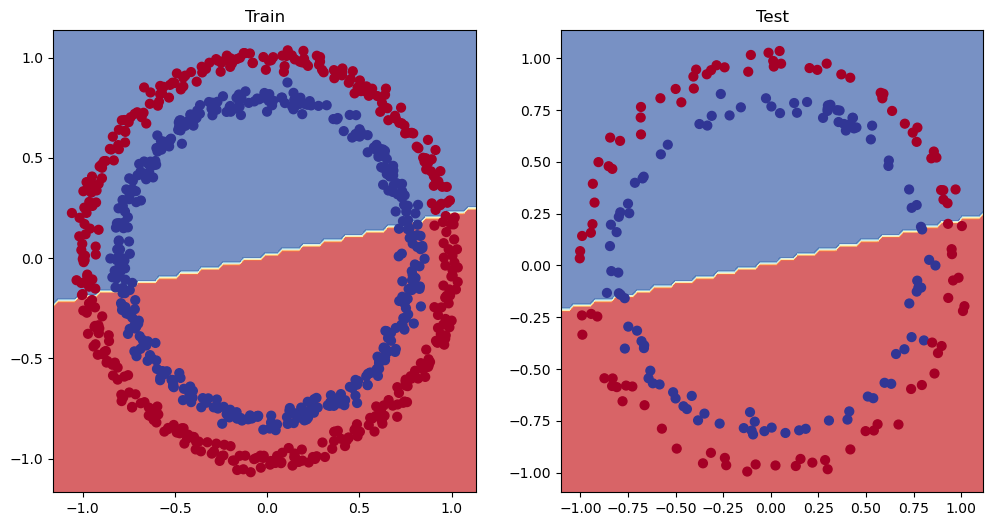

In [68]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Hmmm.

Our model is still drawing a straight line between the red and blue dots.

If our model is drawing a straight line, could it model linear data?

In [69]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [70]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
      len(y_train_regression),
      len(X_test_regression),
      len(y_test_regression))

80 80 20 20


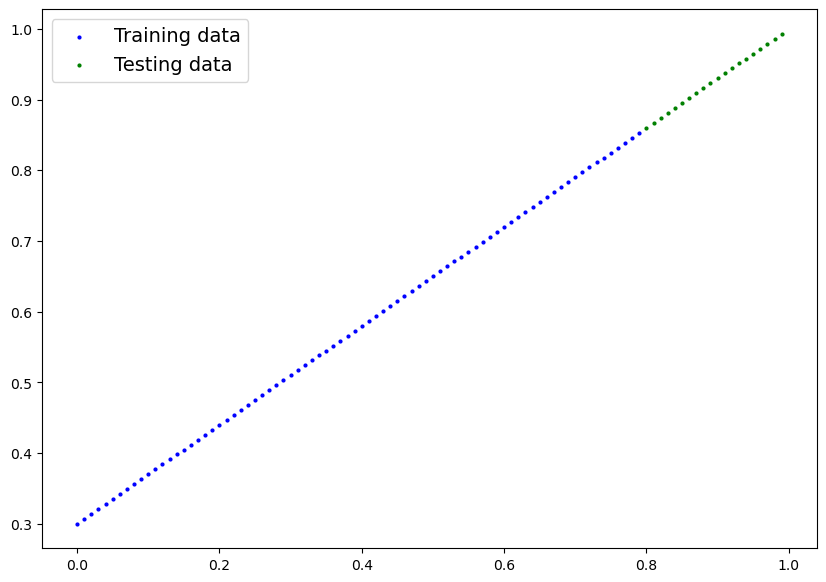

In [71]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression
                 );

In [72]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [73]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [74]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_2(X_test_regression)
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


Okay, unlike model_1 on the classification data, it looks like model_2's loss is actually going down.

Let's plot its predictions to see if that's so.

And remember, since our model and data are using the target device, and this device may be a GPU, however, our plotting function uses matplotlib and matplotlib can't handle data on the GPU.

To handle that, we'll send all of our data to the CPU using .cpu() when we pass it to plot_predictions().

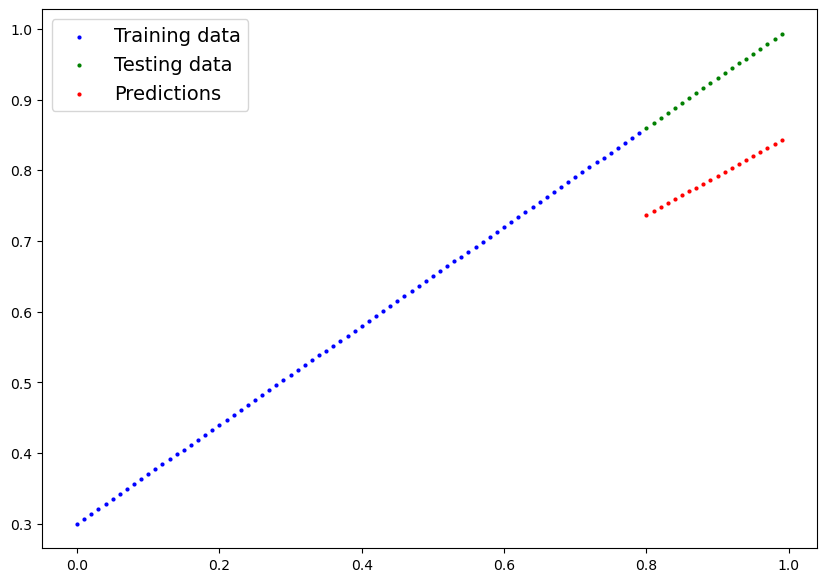

In [75]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

Alright, it looks like our model is able to do far better than random guessing on straight lines.

This is a good thing.

It means our model at least has some capacity to learn.

Note: A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.

This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then overfitting (making the model perform too well) on that small example before increasing the amount of data or the model size/design to reduce overfitting.

So what could it be?

Let's find out.

## 6. The missing piece: non-linearity

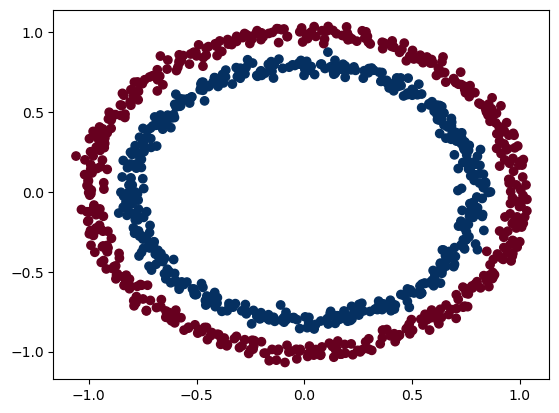

In [76]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42,
                    )

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [77]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [83]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 20)
        self.layer_2 = nn.Linear(20, 20)
        self.layer_3 = nn.Linear(20, 1)
        self.relu = nn.ReLU()
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.relu(self.layer_1(x))))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [84]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [85]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69448, Accuracy: 47.62% | Test Loss: 0.69197, Test Accuracy: 54.00%
Epoch: 100 | Loss: 0.69102, Accuracy: 53.12% | Test Loss: 0.68961, Test Accuracy: 56.50%
Epoch: 200 | Loss: 0.68750, Accuracy: 56.88% | Test Loss: 0.68704, Test Accuracy: 57.00%
Epoch: 300 | Loss: 0.68379, Accuracy: 59.62% | Test Loss: 0.68357, Test Accuracy: 59.50%
Epoch: 400 | Loss: 0.67821, Accuracy: 63.12% | Test Loss: 0.67807, Test Accuracy: 63.00%
Epoch: 500 | Loss: 0.66898, Accuracy: 69.50% | Test Loss: 0.66913, Test Accuracy: 72.00%
Epoch: 600 | Loss: 0.65292, Accuracy: 75.38% | Test Loss: 0.65433, Test Accuracy: 77.00%
Epoch: 700 | Loss: 0.62314, Accuracy: 85.62% | Test Loss: 0.62753, Test Accuracy: 84.00%
Epoch: 800 | Loss: 0.56539, Accuracy: 94.62% | Test Loss: 0.57623, Test Accuracy: 94.00%
Epoch: 900 | Loss: 0.45988, Accuracy: 99.38% | Test Loss: 0.48168, Test Accuracy: 98.00%


Ho ho! That's looking far better!

In [86]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

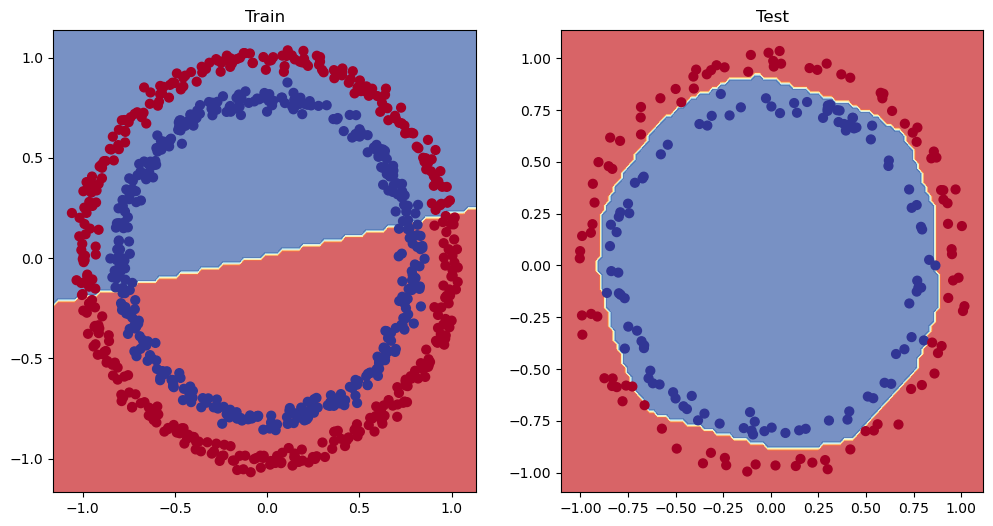

In [87]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Nice! Not perfect but still far better than before.

Potentially you could try a few tricks to improve the test accuracy of the model? (hint: head back to section 5 for tips on improving the model)

## 7. Replicating non-linear activation functions
We saw before how adding non-linear activation functions to our model can help it to model non-linear data.

Note: Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Right now we've been working with dots on a 2D plot. But imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes. Or text from Wikipedia you'd like to summarize, there's lots of different ways words can be put together (linear and non-linear patterns).

But what does a non-linear activation look like?

How about we replicate some and what they do?

Let's start by creating a small amount of data.

In [88]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

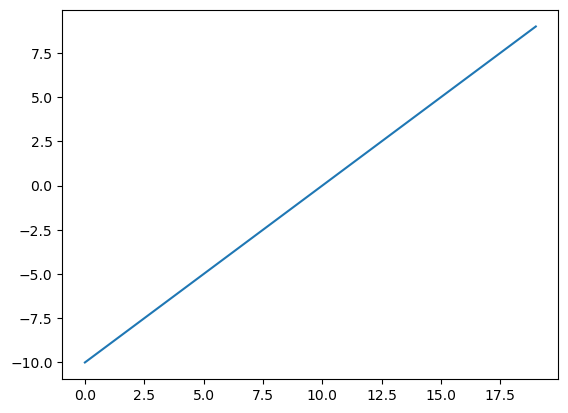

In [89]:
plt.plot(A)

A straight line, nice.

Now let's see how the ReLU activation function influences it.

And instead of using PyTorch's ReLU (torch.nn.ReLU), we'll recreate it ourselves.

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [90]:
def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

It looks like our ReLU function worked, all of the negative values are zeros.

Let's plot them.

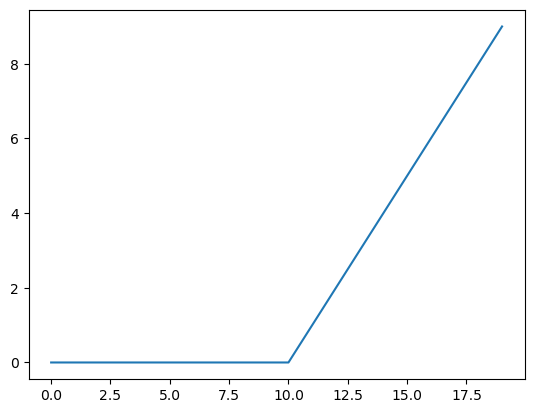

In [91]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

Nice! That looks exactly like the shape of the ReLU function on the Wikipedia page for ReLU).

How about we try the sigmoid function we've been using?

The sigmoid function formula goes like so:

$$ out_i = \frac{1}{1+e^{-input_i}} $$

Or using $x$ as input:

$$ S(x) = \frac{1}{1+e^{-x_i}} $$

Where $S$ stands for sigmoid, $e$ stands for exponential (torch.exp()) and $i$ stands for a particular element in a tensor.

Let's build a function to replicate the sigmoid function with PyTorch.



In [92]:
# Create a custom sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

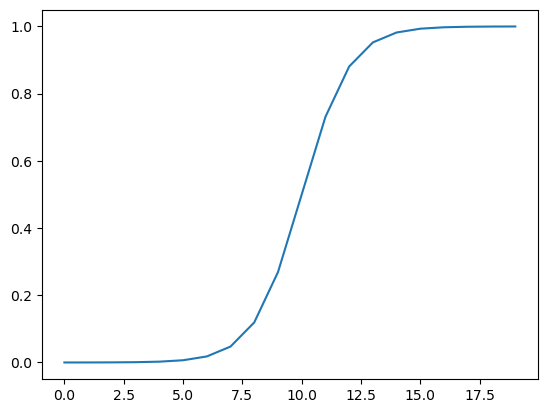

In [93]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));


Looking good! We've gone from a straight line to a curved line.

Now there's plenty more non-linear activation functions that exist in PyTorch that we haven't tried.

But these two are two of the most common.

And the point remains, what patterns could you draw using an unlimited amount of linear (straight) and non-linear (not straight) lines?

Almost anything right?

That's exactly what our model is doing when we combine linear and non-linear functions.

Instead of telling our model what to do, we give it tools to figure out how to best discover patterns in the data.

And those tools are linear and non-linear functions.

## 8. Putting things together by building a multi-class PyTorch model
Recall a binary classification problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a multi-class classification problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).



To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's make_blobs() method.

This method will create however many classes (using the centers parameter) we want.

Specifically, let's do the following:

- Create some multi-class data with make_blobs().
- Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
- Split the data into training and test sets using train_test_split().
- Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3., 2., 2., 1., 1.])


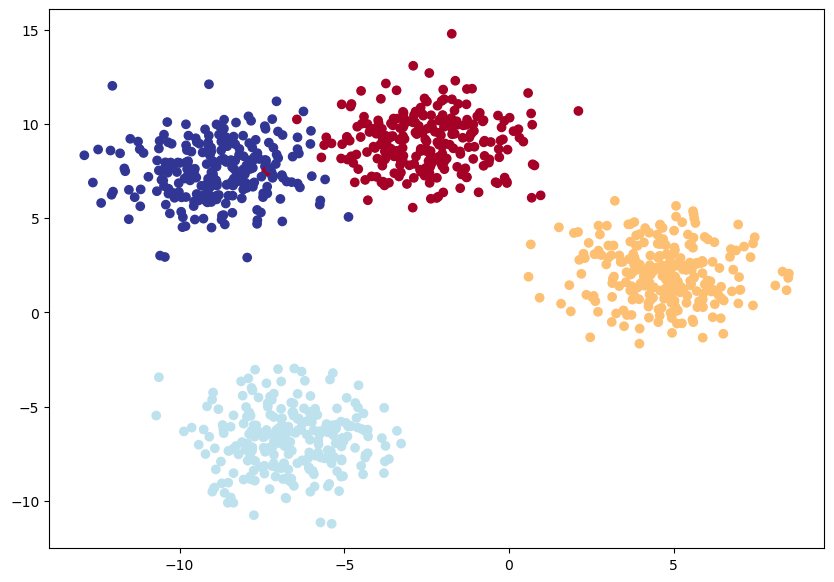

In [94]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

Nice! Looks like we've got some multi-class data ready to go.

Let's build a model to separate the coloured blobs.

Question: Does this dataset need non-linearity? Or could you draw a succession of straight lines to separate it?

We've created a few models in PyTorch so far.

You might also be starting to get an idea of how flexible neural networks are.

How about we build one similar to model_3 but this is still capable of handling multi-class data?

To do so, let's create a subclass of nn.Module that takes in three hyperparameters:

- input_features - the number of X features coming into the model.
- output_features - the ideal numbers of output features we'd like (this will be equivalent to NUM_CLASSES or the number of classes in your multi-class classification problem).
- hidden_units - the number of hidden neurons we'd like each hidden layer to use.
Since we're putting things together, let's setup some device agnostic code (we don't have to do this again in the same notebook, it's only a reminder).

Then we'll create the model class using the hyperparameters above.

In [95]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [97]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(hidden_units, hidden_units),
            # nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(NUM_FEATURES, NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

Since we're working on a multi-class classification problem, we'll use the nn.CrossEntropyLoss() method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our model_4 parameters.

In [98]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [100]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
print(model_4(X_blob_train.to(device))[:5])

tensor([[ 0.8696, -0.7083, -0.3200,  0.5513],
        [-0.1989, -2.0320,  0.4267, -1.2864],
        [-0.9819, -0.0741,  1.0288, -1.7247],
        [-0.6449, -0.4877,  0.7777, -1.4029],
        [-0.2937, -1.7872,  0.4998, -1.3371]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [101]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

Wonderful, our model is predicting one value for each class that we have.

Do you remember what the raw outputs of our model are called?

Hint: it rhymes with "frog splits" (no animals were harmed in the creation of these materials).

If you guessed logits, you'd be correct.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

That's where the softmax activation function comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

If this doesn't make sense, let's see in code.

In [102]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.8161, -0.8846, -0.2847,  0.4252],
        [-0.9359, -2.0669,  0.9583, -2.2816],
        [-0.6742, -0.0694,  0.8067, -1.3123],
        [ 0.6858, -0.5307, -0.1840,  0.3610],
        [ 0.1430, -1.9414,  0.1816, -0.8017]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.4563, 0.0833, 0.1518, 0.3087],
        [0.1215, 0.0392, 0.8077, 0.0316],
        [0.1289, 0.2361, 0.5669, 0.0681],
        [0.4102, 0.1215, 0.1719, 0.2964],
        [0.3918, 0.0487, 0.4072, 0.1523]], device='cuda:0',
       grad_fn=<SliceBackward0>)


Hmm, what's happened here?

It may still look like the outputs of the softmax function are jumbled numbers (and they are, since our model hasn't been trained and is predicting using random patterns) but there's a very specific thing different about each sample.

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

Let's check.

In [103]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

These prediction probabilities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using torch.argmax().

In [104]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.4563, 0.0833, 0.1518, 0.3087], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 3.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

Note: To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

Alright, now we've got all of the preparation steps out of the way, let's write a training and testing loop to improve and evaluate our model.

We've done many of these steps before so much of this will be practice.

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

Let's train the model for epochs=100 and evaluate it every 10 epochs.

In [106]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.long().to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.long().to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.92116, Acc: 26.00% | Test Loss: 0.85459, Test Acc: 55.00%
Epoch: 10 | Loss: 0.28521, Acc: 97.12% | Test Loss: 0.23787, Test Acc: 98.00%
Epoch: 20 | Loss: 0.11618, Acc: 99.00% | Test Loss: 0.10434, Test Acc: 98.50%
Epoch: 30 | Loss: 0.07650, Acc: 99.00% | Test Loss: 0.06791, Test Acc: 98.50%
Epoch: 40 | Loss: 0.06006, Acc: 99.00% | Test Loss: 0.05209, Test Acc: 99.00%
Epoch: 50 | Loss: 0.05133, Acc: 99.00% | Test Loss: 0.04346, Test Acc: 99.00%
Epoch: 60 | Loss: 0.04599, Acc: 99.00% | Test Loss: 0.03807, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04242, Acc: 99.00% | Test Loss: 0.03440, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03989, Acc: 99.00% | Test Loss: 0.03174, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03800, Acc: 99.00% | Test Loss: 0.02972, Test Acc: 99.50%


It looks like our trained model is performing pretty well.

But to make sure of this, let's make some predictions and visualize them.

In [108]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
print(y_logits[:10])

tensor([[  9.0456,  15.0193,  -8.9350,  -4.0027],
        [ -0.7123, -18.4017,  -2.2680,   4.8906],
        [-13.7129, -24.1734,  13.9078,   5.7032],
        [  4.8120,   9.9222,  -4.2728,  -2.8219],
        [ 10.0808,   5.7406, -12.0556,  -1.2943],
        [ -1.4195, -22.5796,  -2.1153,   6.0351],
        [-12.6774, -19.5705,  13.3991,   4.4586],
        [  7.0078,  -0.7074,  -9.1888,   0.3454],
        [-16.1919, -32.0740,  15.7126,   7.7945],
        [  7.9838,   1.6031, -10.0499,  -0.2502]], device='cuda:0')


Alright, looks like our model's predictions are still in logit form.

Though to evaluate them, they'll have to be in the same form as our labels (y_blob_test) which are in integer form.

Let's convert our model's prediction logits to prediction probabilities (using torch.softmax()) then to prediction labels (by taking the argmax() of each sample).

Note: It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.

For example, y_preds = torch.argmax(y_logits, dim=1), this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.

In [109]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


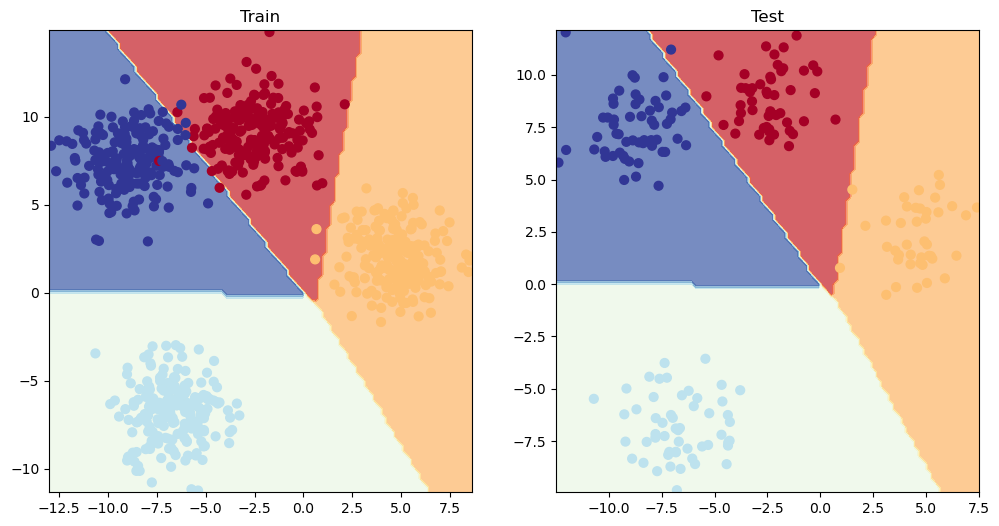

In [110]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

In [113]:
try:
    from torchmetrics import Accuracy
except ModuleNotFoundError:
    # Install torchmetrics without inline comment
    import os
    os.system("pip install torchmetrics")
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

## Exercise

In [117]:
from sklearn.datasets import make_moons

n_samples = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples, noise=0.03, random_state=RANDOM_SEED)

In [118]:
print(f"First 5 X features:\n{X[:5]}")
print(f"First 5 y features:\n{y[:5]}")

First 5 X features:
[[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]
 [ 0.41276802 -0.37638459]
 [-0.84532016  0.52879908]]
First 5 y features:
[1 1 1 1 0]


In [119]:
import pandas as pd

moons = pd.DataFrame(
    {
        'X1': X[:, 0],
        'X2': X[:, 1],
        'label': y
    }
)

moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


In [120]:
moons.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

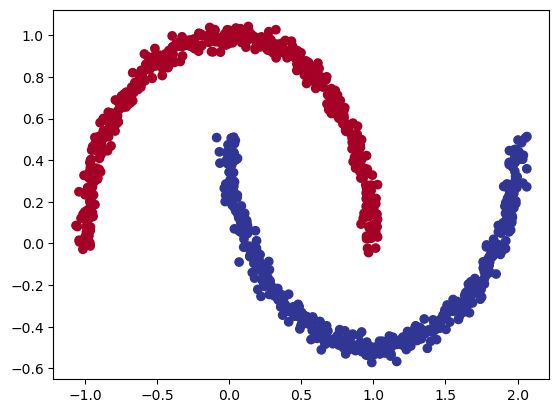

In [121]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [122]:
X.shape, y.shape

((1000, 2), (1000,))

In [123]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"X sample shape: {X_sample.shape} and y sample shape: {y_sample.shape}")

Values for one sample of X: [-0.00933187  0.39098105] and the same for y: 1
X sample shape: (2,) and y sample shape: ()


In [124]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [126]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [127]:
NUM_CLASSES = 2
NUM_FEATURES = 2

In [129]:
class MoonModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_5 = MoonModelV0(NUM_FEATURES, NUM_CLASSES, hidden_units=8).to(device)
model_5

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [130]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_5.parameters(), lr=0.001)

In [131]:
print(model_5(X_train.to(device))[:5])

tensor([[-0.3583, -0.4314],
        [-0.3468, -0.2621],
        [-0.3764, -0.4165],
        [-0.3753, -0.4159],
        [-0.3222, -0.3869]], device='cuda:0', grad_fn=<SliceBackward0>)


In [132]:
y_logits = model_5(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.3209, -0.3853],
        [-0.3708, -0.4469],
        [-0.3258, -0.3914],
        [-0.3799, -0.4581],
        [-0.3474, -0.4181]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[0.5161, 0.4839],
        [0.5190, 0.4810],
        [0.5164, 0.4836],
        [0.5195, 0.4805],
        [0.5176, 0.4824]], device='cuda:0', grad_fn=<SliceBackward0>)


In [133]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [134]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.5161, 0.4839], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [135]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_5.train()

    y_logits = model_5(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_5.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'